### **Name : Yogesh Haresh Bojja (s3789918)**

## **Import Libraries**

In this Section we will import all the required libraries for the assignment.

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd
import tensorflow_hub as hub

import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt
from google.colab import drive

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from scipy.interpolate import interp1d
import numpy as np
from scipy.ndimage.interpolation import rotate, shift
from PIL import Image

print("Tensorflow version is: ", tf.__version__)
assert tf.__version__[0] == '2'

Tensorflow version is:  2.6.0


# **Define Plotter function**

Here we will define plotter() required for plotting the graphs.

In [2]:
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0], title="None"):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    
    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_Val')

  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.title(title)
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

# **Import Data**

We will be importing the data from GDrive here.

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
!cp /content/drive/MyDrive/COSC2779_Deep_Learning/'Assignment 02'/Rumour_data.zip .

In [9]:
!unzip -q -o Rumour_data.zip

In [10]:
!rm -r Rumour_data.zip __MACOSX

Load twitter dataset here.

In [11]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("./Rumour_data/twitter_dataset.csv")

# **Data Cleaning and Preparation**

Data Cleaning is done in this section. 

Each tweet has dependency on its Source tweet. When Source and tweet both are passed as a sentence pair(Source tweet, Reply tweet) to the model it gives better results. Twitter dataset contains Source_Msg_ID for every tweets. Tweet which itself is a source has its Source_Msg_ID as '-1'. Thus, we will be mapping all the tweets with its source tweet and store it in a new column 'Source' as shown below.

In [12]:
def get_source(df1):
    df1['Source'] = df[df['Msg_ID'] == df1['Source_Msg_ID']]['Text'].values[0]
    return df1

Delete tweets which are sources as we have already mapped them in new column i.e. 'Source'.

In [13]:
df1 = df[df['Source_Msg_ID'] != -1]
df1 = df1.apply(get_source, axis=1)
df = df1[['Source', 'Text', 'Class']]

Data frame looks as below after performing above operations.

In [14]:
df.head(3)

,Source,Text,Class
1,#4U9525: Robin names Andreas Lubitz as the cop...,@thatjohn Have they named the pilot?,query
2,#4U9525: Robin names Andreas Lubitz as the cop...,@thatjohn @mschenk,comment
4,RT @khjelmgaard: German media reporting #Andre...,@tinkalee_12 @USATODAY @khjelmgaard #F4Phantom...,comment


In this section we will be using regular expressions for cleaning tweets. Twitter handles, URLs are irrelevant thus we discard them. Tags are very import in case of revealing the root of the tweet and can be identified for grouping of tweets, for example, #BlackLivesMatter was trending recently and tweets with this tag can be identified in one group. Therefore, we do not discard Tags from the tweets. Tags start with '#' always. '?' tells whether the tweet is query and '!' identifies the tweet as comment in most of the cases, hence we do not discard them. For the above statements the paper referred were (https://sentic.net/sentire2019xuan.pdf) and (https://aclanthology.org/S19-2148.pdf)

In [15]:
import re
def clean_text(tweet):
  temp = re.sub(r"@\w+: ", "", tweet)
  temp = re.sub(r"@\w+ ", "", temp)
  temp = re.sub(r"@\w+", "", temp)
  url_re = r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
  temp = re.sub(url_re, "", temp)
  temp = temp.strip()
  temp = re.sub("RT ", "", temp)

  return temp

In [ ]:
df['Text'] = df['Text'].apply(clean_text)
df['Source'] = df['Source'].apply(clean_text)

We dont want our model to treat 'Confirm' and 'confirm' differently because they mean the same but according to this paper (https://turcomat.org/index.php/turkbilmat/article/view/9398/7232) in some cases people try to express their strong feeling by writing the word in capitals for example, 'people need to STOP RACISM'. Thus we will convert the whole string to lower case except where its in Upper case.

In [17]:
def convert_init_to_lower(x):
    return " ".join([word if word.isupper() else word.lower() for word in x.split(" ")])

In [ ]:
df['Source'] = df['Source'].apply(convert_init_to_lower)
df['Text'] = df['Text'].apply(convert_init_to_lower)

Dataframe looks as follows after performing the above operations

In [19]:
df.head(3)

,Source,Text,Class
1,#4U9525: robin names andreas lubitz as the cop...,have they named the pilot?,query
2,#4U9525: robin names andreas lubitz as the cop...,,comment
4,german media reporting #andreaslubitz had a 's...,#f4phantom #crash #500mph #hit #concretewall #...,comment


Words like a, an etc. which are stopwords are trivial, hence we discard them. 

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['Source'] = df['Source'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

There are some duplicate rows in the dataset. We discard them here.

In [21]:
df = df.drop_duplicates(keep="first")

We exclude tweets with blank message.

In [22]:
df = df[df['Text']!=""]

As we require sentence pair, we concatenate the source with the reply by '|' operator and store it in the new column 'Source+Reply'.

In [23]:
df['Source+Reply'] = df['Source']+" | "+df['Text']
df = df[['Source+Reply', 'Class']]

Encoding of categorical class to integer is done here.

In [24]:
classes = df['Class'].unique().tolist()
encoding = dict({
    classes[0] : classes.index(classes[0]),
    classes[1] : classes.index(classes[1]),
    classes[2] : classes.index(classes[2]),
    classes[3] : classes.index(classes[3])
})
print(encoding)
for cls in classes:
  df['Class'].replace(to_replace=cls, value=encoding[cls], inplace=True)


{'query': 0, 'comment': 1, 'deny': 2, 'support': 3}


In [25]:
df.head(3)

,Source+Reply,Class
1,#4U9525: robin names andreas lubitz copilot fl...,0
4,german media reporting #andreaslubitz 'serious...,1
5,german media reporting #andreaslubitz 'serious...,1


In the below pie chart it is clearly visible that our dataset is imbalanced. In this paper (https://aclanthology.org/2020.rdsm-1.4.pdf) various techniques like RUS, ROS, SMOTE are mentioned. SMOTE is good but it makes lot of ambiguos records. ROS means Random over sampling, this technique is computation friendly but it induces overfitting. I have selected ROS and the overfitting problem can be solved later by regularization, dropout.

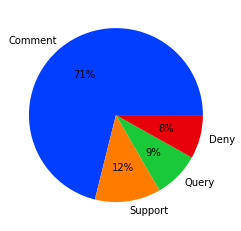

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['Comment', 'Support', 'Query', 'Deny']

colors = sns.color_palette('bright')[0:4]

plt.pie(df['Class'].value_counts(), labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [27]:
df['Class'].value_counts()

1    4278
3     737
0     513
2     488
Name: Class, dtype: int64

In [28]:
df_0 = df[df['Class']==0]
df_1 = df[df['Class']==1]
df_2 = df[df['Class']==2]
df_3 = df[df['Class']==3]

Over sampling is done below.

In [29]:
maxx = df["Class"].value_counts()[1]
df_0 = df_0.sample(maxx, replace = True)
df_2 = df_2.sample(maxx, replace = True)
df_3 = df_3.sample(maxx, replace = True)

In [30]:
df = pd.concat([df_0, df_1, df_2, df_3], axis=0)

In [31]:
df.shape

(17112, 2)

In [32]:
df.head(2)

,Source+Reply,Class
6117,black lives matter THUGS blocking emergency cr...,0
1252,guy got far leads suspect seems. | wat news ag...,0


After Oversampling the pie chart looks as follows

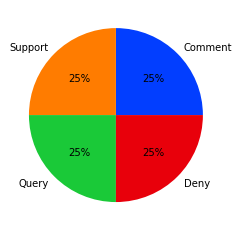

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['Comment', 'Support', 'Query', 'Deny']

colors = sns.color_palette('bright')[0:4]

plt.pie(df['Class'].value_counts(), labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

Convert class to one hot encoded format.

In [34]:
target = np.array(df['Class'].values.tolist())
from tensorflow.keras.utils import to_categorical
target = to_categorical(target, dtype="uint8")

We have split the data into 70% train, 15% validation and 15% test data. 

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(df['Source+Reply'], target, test_size=0.3, shuffle=True,random_state=0, stratify=df['Class'])
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, shuffle=True,random_state=0)

In [36]:
print("Length of Training Data : ", len(X_train))
print("Length of Validation Data : ", len(X_val))
print("Length of Test Data : ", len(X_test))

Length of Training Data :  11978
Length of Validation Data :  2567
Length of Test Data :  2567


# **Build Baseline Model**

In [37]:
!pip install tensorflow-text
import tensorflow_hub as hub
import tensorflow_text as text

     |████████████████████████████████| 4.4 MB 5.9 MB/s 


For our project we have used Electra-bert model as it performs best among all the model for text classification with less compuational resources as mentioned in this link https://ai.googleblog.com/2020/03/more-efficient-nlp-model-pre-training.html and paper (https://arxiv.org/abs/2003.10555)

In [38]:
bert_model_name = 'electra_small' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'electra_large':
        'https://tfhub.dev/google/electra_large/2'
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_small/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


This is th example how our text will feed into the bert. Source tweet and reply tweet will be seperated by '|' operater. This operator will remain constant throught the dataset hence won't cause any difference. 1064 is the encoded value of the operator as seen in the output of preprocesser.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['Source | Reply']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [[ 101 3120 1064 7514  102    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Input Mask : [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/google/electra_small/2
Pooled Outputs Shape:(1, 256)
Pooled Outputs Values:[ 0.48572674  0.623785   -0.5381234  -0.54806304  0.5384336  -0.5692899
  0.5404603   0.92493045  0.7219062   0.4104752  -0.32309625 -0.77266437]
Sequence Outputs Shape:(1, 128, 256)
Sequence Outputs Values:[[ 0.53045225  0.7311771  -0.60151035 ...  1.1741985  -0.47287518
  -0.11839285]
 [ 0.7559128   1.0063527  -0.99594694 ... -0.13342717  0.2638672
   0.8845434 ]
 [ 1.1767806   0.4440827  -0.27217764 ...  0.62797886  0.11494857
   0.01177209]
 ...
 [ 1.4324863   0.67511106  0.31879532 ...  0.24001853 -0.26919395
   0.5744383 ]
 [ 1.2735456   0.7282126   0.29511654 ...  0.14058019 -0.39234105
   0.22558051]
 [ 1.2754353   0.69785523  0.44495094 ...  0.18514825 -0.44001272
   0.33173665]]


In the base model we have used  'pooled output' and then feed it to the Dense layer.

In [41]:
def baseline_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [42]:
classifier_model = baseline_model()


In [43]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  13548801    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

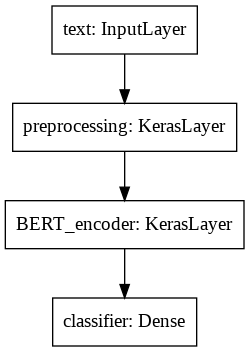

In [44]:
tf.keras.utils.plot_model(classifier_model)

In [45]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = tf.metrics.CategoricalAccuracy()

In [46]:
classifier_model.compile(optimizer='adam',
                         loss=loss,
                         metrics=metrics)

In [47]:
def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
  ]

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
m_histories = {}
m_histories['baseline_model'] = classifier_model.fit(X_train, Y_train,
                               validation_data=(X_val, Y_val),
                               epochs=3, callbacks=get_callbacks(), verbose = 1)

Training model with https://tfhub.dev/google/electra_small/2
Epoch 1/3
375/375 [==============================] - 99s 237ms/step - loss: 1.3410 - categorical_accuracy: 0.3462 - val_loss: 1.2807 - val_categorical_accuracy: 0.4059
Epoch 2/3
375/375 [==============================] - 87s 233ms/step - loss: 1.2643 - categorical_accuracy: 0.4259 - val_loss: 1.2442 - val_categorical_accuracy: 0.4472
Epoch 3/3
375/375 [==============================] - 87s 232ms/step - loss: 1.2389 - categorical_accuracy: 0.4485 - val_loss: 1.2255 - val_categorical_accuracy: 0.4573


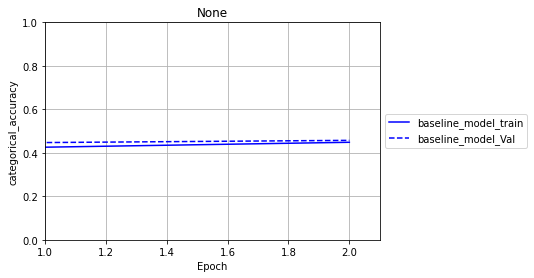

In [ ]:
plotter(m_histories, metric='categorical_accuracy')

From the above plot it can be said that there is no overfitting but the accuracy is low. Accuracy is just 45% as seen below.

In [ ]:
r = classifier_model.evaluate(X_test, Y_test)
print("Loss = ", r[0])
print("Accuracy = ",r[1])

81/81 [==============================] - 16s 196ms/step - loss: 1.2265 - categorical_accuracy: 0.4531
Loss =  1.2265344858169556
Accuracy =  0.45305803418159485


In [ ]:
y_pred = classifier_model.predict(X_test)

In [ ]:
model_pred = []
for i in y_pred:
  model_pred.append(np.argmax(i))

actual_value = []
for i in Y_test:
  actual_value.append(np.argmax(i))

Confusion matrix after prediction over test data is shown below. 

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(actual_value, model_pred)

array([[364,  71,  97, 103],
       [ 82, 175, 209, 195],
       [ 60, 129, 322, 133],
       [ 75, 101, 149, 302]])

# **Build Complex Model and Fine tuning**

For the complex model we have used CNN on top of the BERT model. This approach was giving high performance as per this paper (https://arxiv.org/pdf/1408.5882.pdf). Instead of pooled output we have used sequence output in this model which will be then fed to convolution layer.

In [48]:
def complex_model(dropout = None, activation='sigmoid', regularizer=None):
  print("Activation selected = ", activation)
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['sequence_output']
  out = tf.keras.layers.Conv1D(32, (2), activation=activation)(net)
  
    
  out = tf.keras.layers.Conv1D(64, (2), activation=activation)(out)

  out = tf.keras.layers.GlobalMaxPool1D()(out)
    
  if regularizer is not None:
    out = tf.keras.layers.Dense(512, activation=activation, kernel_regularizer=regularizer)(out)
  else:  
    out = tf.keras.layers.Dense(512, activation=activation)(out)

  if dropout is not None:  
    print("Dropout selected = ",dropout)
    out = tf.keras.layers.Dropout(dropout)(out)
  else:
    print("Dropout not selected")

  out = tf.keras.layers.Dense(4, activation="softmax", name='classifier')(out)
    
  return tf.keras.Model(text_input, out)

In [ ]:
complex_model = complex_model()

Activation selected =  sigmoid
Dropout not selected


In [ ]:
complex_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  13548801    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [49]:
def compile_fit(model, optimizer=tf.keras.optimizers.Adam(), callbacks=None, epochs=3):
  model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
  return model.fit(X_train, Y_train,
                                validation_data=(X_val, Y_val),
                                epochs=epochs, callbacks=callbacks, verbose = 1)

## **Select Activation**

In [ ]:
m_histories = {}

model1 = complex_model(activation='sigmoid')
m_histories['sigmoid'] = compile_fit(model1, callbacks=get_callbacks(), epochs=3)

Activation selected =  sigmoid
Dropout not selected
Epoch 1/3
375/375 [==============================] - 109s 255ms/step - loss: 1.2333 - categorical_accuracy: 0.4724 - val_loss: 1.0625 - val_categorical_accuracy: 0.4936
Epoch 2/3
375/375 [==============================] - 92s 247ms/step - loss: 1.0154 - categorical_accuracy: 0.5342 - val_loss: 0.9923 - val_categorical_accuracy: 0.5279
Epoch 3/3
375/375 [==============================] - 95s 253ms/step - loss: 0.8951 - categorical_accuracy: 0.6082 - val_loss: 0.8688 - val_categorical_accuracy: 0.6260


In [ ]:
model2 = complex_model(activation='relu')
m_histories['relu'] = compile_fit(model2, callbacks=get_callbacks(), epochs=3)

Activation selected =  relu
Dropout not selected
Epoch 1/3
375/375 [==============================] - 105s 253ms/step - loss: 1.0974 - categorical_accuracy: 0.5375 - val_loss: 0.8867 - val_categorical_accuracy: 0.6323
Epoch 2/3
375/375 [==============================] - 94s 250ms/step - loss: 0.7115 - categorical_accuracy: 0.7257 - val_loss: 0.5994 - val_categorical_accuracy: 0.7604
Epoch 3/3
375/375 [==============================] - 95s 253ms/step - loss: 0.4685 - categorical_accuracy: 0.8176 - val_loss: 0.5018 - val_categorical_accuracy: 0.8111


In [ ]:
model3 = complex_model(activation='elu')
m_histories['elu'] = compile_fit(model3, callbacks=get_callbacks(), epochs=3)

Activation selected =  elu
Dropout not selected
Epoch 1/3
375/375 [==============================] - 103s 248ms/step - loss: 1.0897 - categorical_accuracy: 0.5829 - val_loss: 0.7808 - val_categorical_accuracy: 0.6950
Epoch 2/3
375/375 [==============================] - 90s 241ms/step - loss: 0.6775 - categorical_accuracy: 0.7341 - val_loss: 0.5814 - val_categorical_accuracy: 0.7764
Epoch 3/3
375/375 [==============================] - 91s 244ms/step - loss: 0.4584 - categorical_accuracy: 0.8299 - val_loss: 0.4459 - val_categorical_accuracy: 0.8399


In [ ]:
model4 = complex_model(activation='leaky_relu')
m_histories['leaky_relu'] = compile_fit(model4, callbacks=get_callbacks(), epochs=3)

Activation selected =  leaky_relu
Dropout not selected
Epoch 1/3
375/375 [==============================] - 100s 241ms/step - loss: 1.1395 - categorical_accuracy: 0.5513 - val_loss: 0.8924 - val_categorical_accuracy: 0.6342
Epoch 2/3
375/375 [==============================] - 89s 236ms/step - loss: 0.7232 - categorical_accuracy: 0.7168 - val_loss: 0.6720 - val_categorical_accuracy: 0.7250
Epoch 3/3
375/375 [==============================] - 88s 236ms/step - loss: 0.4816 - categorical_accuracy: 0.8195 - val_loss: 0.4499 - val_categorical_accuracy: 0.8298


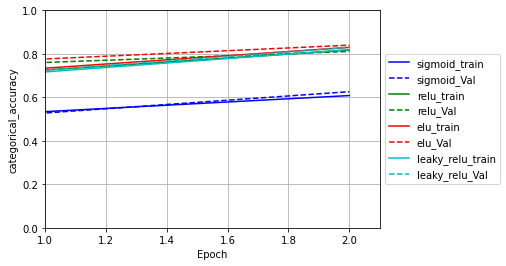

In [ ]:
plotter(m_histories, metric='categorical_accuracy', title="")

There is no overfitting in the model for any activation function. 'elu' activation function gives best result of the all. We will select 'elu' for further analysis.

## **Select Regularization**

In [ ]:
m_histories = {}
regularizer_l2 = tf.keras.regularizers.l2(0.001)
model3 = complex_model(regularizer=regularizer_l2, activation='elu')
m_histories['L2_regularizer'] = compile_fit(model3, callbacks=get_callbacks(), epochs=3)

regularizer_l1 = tf.keras.regularizers.l1(0.001)
model4 = complex_model(regularizer=regularizer_l1, activation='elu')
m_histories['L1_regularizer'] = compile_fit(model4, callbacks=get_callbacks(), epochs=3)

Activation selected =  elu
Dropout not selected
Epoch 1/3
375/375 [==============================] - 100s 241ms/step - loss: 1.1904 - categorical_accuracy: 0.5761 - val_loss: 0.8447 - val_categorical_accuracy: 0.6852
Epoch 2/3
375/375 [==============================] - 89s 237ms/step - loss: 0.7021 - categorical_accuracy: 0.7449 - val_loss: 0.5903 - val_categorical_accuracy: 0.7959
Epoch 3/3
375/375 [==============================] - 89s 237ms/step - loss: 0.4712 - categorical_accuracy: 0.8410 - val_loss: 0.4769 - val_categorical_accuracy: 0.8364
Activation selected =  elu
Dropout not selected
Epoch 1/3
375/375 [==============================] - 101s 242ms/step - loss: 1.5910 - categorical_accuracy: 0.5505 - val_loss: 1.0688 - val_categorical_accuracy: 0.5859
Epoch 2/3
375/375 [==============================] - 90s 240ms/step - loss: 0.9322 - categorical_accuracy: 0.6635 - val_loss: 0.8130 - val_categorical_accuracy: 0.7242
Epoch 3/3
375/375 [==============================] - 90s 239ms

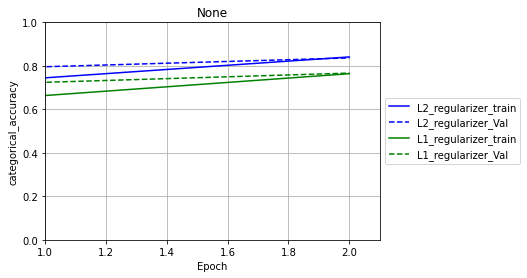

In [ ]:
plotter(m_histories, metric='categorical_accuracy')

L2 regularization gives good performance as compared to the L1 regularization. We will select L2 regularization along with 'elu' for further analysis.

## **Select Dropout**

In [ ]:
m_histories = {}
dropout = 0.1
model4 = complex_model(dropout=dropout, regularizer=regularizer_l2, activation='elu')
m_histories['dropout_0.1'] = compile_fit(model4, callbacks=get_callbacks(), epochs=3)

dropout = 0.3
model5 = complex_model(dropout=dropout, regularizer=regularizer_l2, activation='elu')
m_histories['dropout_0.3'] = compile_fit(model5, callbacks=get_callbacks(), epochs=3)

Activation selected =  elu
Dropout selected =  0.1
Epoch 1/3
375/375 [==============================] - 101s 242ms/step - loss: 1.2284 - categorical_accuracy: 0.5598 - val_loss: 0.9282 - val_categorical_accuracy: 0.6408
Epoch 2/3
375/375 [==============================] - 89s 239ms/step - loss: 0.7863 - categorical_accuracy: 0.7081 - val_loss: 0.6273 - val_categorical_accuracy: 0.7818
Epoch 3/3
375/375 [==============================] - 90s 239ms/step - loss: 0.5318 - categorical_accuracy: 0.8140 - val_loss: 0.5112 - val_categorical_accuracy: 0.8274
Activation selected =  elu
Dropout selected =  0.3
Epoch 1/3
375/375 [==============================] - 106s 243ms/step - loss: 1.1933 - categorical_accuracy: 0.5747 - val_loss: 0.8627 - val_categorical_accuracy: 0.6778
Epoch 2/3
375/375 [==============================] - 90s 239ms/step - loss: 0.7161 - categorical_accuracy: 0.7455 - val_loss: 0.5997 - val_categorical_accuracy: 0.7900
Epoch 3/3
375/375 [==============================] - 89s

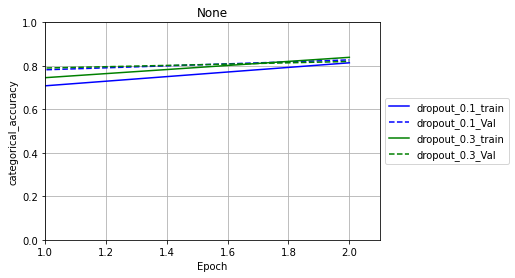

In [ ]:
plotter(m_histories, metric='categorical_accuracy')

Dropout of 0.3 is less overfitting than that of 0.1 and gives almost same performance. Hence we will select dropout value as 0.3. For optimizers, BERT uses adams optimizer hence we will stick to it.

Our final model will have below parameter which were found best in the above analysis.
1. activation = 'elu'
2. regularization = 'L2'
3. dropout = 0.3
4. optimizer = adam

## **Save Final Model**

In [50]:
m_histories = {}
regularizer_l2 = tf.keras.regularizers.l2(0.001)
final_model = complex_model(dropout=0.3, regularizer=regularizer_l2, activation='elu')
m_histories['final_model'] = compile_fit(final_model, callbacks=get_callbacks(), epochs=4)

Activation selected =  elu
Dropout selected =  0.3
Epoch 1/4
375/375 [==============================] - 140s 265ms/step - loss: 1.2054 - categorical_accuracy: 0.5170 - val_loss: 0.9887 - val_categorical_accuracy: 0.6295
Epoch 2/4
375/375 [==============================] - 98s 260ms/step - loss: 0.7852 - categorical_accuracy: 0.7235 - val_loss: 0.7536 - val_categorical_accuracy: 0.7398
Epoch 3/4
375/375 [==============================] - 98s 261ms/step - loss: 0.5347 - categorical_accuracy: 0.8291 - val_loss: 0.5928 - val_categorical_accuracy: 0.7986
Epoch 4/4
375/375 [==============================] - 98s 260ms/step - loss: 0.3989 - categorical_accuracy: 0.8840 - val_loss: 0.4652 - val_categorical_accuracy: 0.8629


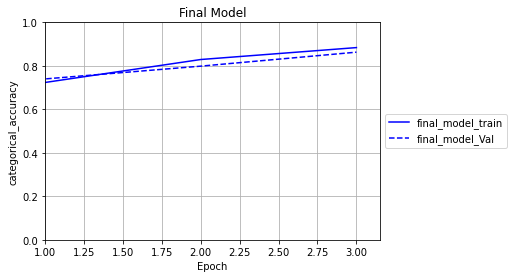

In [81]:
plotter(m_histories, metric='categorical_accuracy', title="Final Model")

## **Evaluation on Test Data**

In this section we are evaluating on the test data. Accuracy is found to be 85%.

In [ ]:
r = final_model.evaluate(X_test, Y_test)
print("Loss = ", r[0])
print("Accuracy = ",r[1])

81/81 [==============================] - 17s 208ms/step - loss: 0.4816 - categorical_accuracy: 0.8559
Loss =  0.4815808832645416
Accuracy =  0.8558628559112549


In [ ]:
y_pred = final_model.predict(X_test)

In [ ]:
model_pred = []
for i in y_pred:
  model_pred.append(np.argmax(i))

actual_value = []
for i in Y_test:
  actual_value.append(np.argmax(i))

Confusion matrix for predicting on test data is shown below.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(actual_value, model_pred)

array([[620,  14,   0,   1],
       [ 68, 394,  49, 150],
       [  3,  37, 594,  10],
       [  5,  24,   9, 589]])

# **Testing on Reddit data**

In [52]:
df = pd.read_csv('./Rumour_data/Extra_reddit_dataset.csv')

In [53]:
df.head(3)

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,63uefi,-1,Donald Trump's travel expenses in 10 weeks cos...,None,-1
1,Reply,dfx7l1a,63uefi,But he was from 2001-2009? I don't get what di...,None,comment
2,Reply,dfx88qg,63uefi,Cheney resigned as CEO of Halliburton on July ...,None,comment


In [54]:
def get_source(df1):
    df1['Source'] = df[df['Msg_ID'] == df1['Source_Msg_ID']]['Text'].values[0]
    return df1

In [55]:
source = []
text = []
clas = []
d = pd.DataFrame()
for i in df['Source_Msg_ID']:
  if i != '-1':
    s = df[df['Msg_ID'] == i]['Text'].values[0]
    source.append(s)

text = df[df['Source_Msg_ID']!='-1']['Text']
clas = df[df['Source_Msg_ID']!='-1']['Class']

In [56]:
d['Source'] = source
d['Text'] = text
d['Class'] = clas

In [58]:
d = d.dropna()

In [59]:
df = d

In [60]:
df['Text'] = df['Text'].apply(clean_text)
df['Source'] = df['Source'].apply(clean_text)

In [61]:
df['Source'] = df['Source'].apply(convert_init_to_lower)
df['Text'] = df['Text'].apply(convert_init_to_lower)

In [62]:
df['Source'] = df['Source'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [63]:
df['Source+Reply'] = df['Source']+" | "+df['Text']
df = df[['Source+Reply', 'Class']]

In [64]:
df.head(3)

,Source+Reply,Class
1,donald trump's travel expenses 10 weeks cost U...,comment
2,donald trump's travel expenses 10 weeks cost U...,comment
3,donald trump's travel expenses 10 weeks cost U...,comment


In [ ]:
classes = df['Class'].unique().tolist()
encoding = dict({
    'query' : 0,
    'comment' : 1,
    'deny' : 2,
    'support' : 3
})
print(encoding)
for cls in classes:
  df['Class'].replace(to_replace=cls, value=encoding[cls], inplace=True)

In [66]:
target = np.array(df['Class'].values.tolist())
from tensorflow.keras.utils import to_categorical
target = to_categorical(target, dtype="uint8")

In [67]:
r = final_model.evaluate(df['Source+Reply'], target)
print("Loss = ", r[0])
print("Accuracy = ",r[1])

75/75 [==============================] - 17s 221ms/step - loss: 1.1736 - categorical_accuracy: 0.6499
Loss =  1.1735889911651611
Accuracy =  0.6499372720718384


In [68]:
y_pred = final_model.predict(df['Source+Reply'])

In [69]:
model_pred = []
for i in y_pred:
  model_pred.append(np.argmax(i))

actual_value = []
for i in target:
  actual_value.append(np.argmax(i))

In [70]:
from sklearn.metrics import confusion_matrix
confusion_matrix(actual_value, model_pred)

array([[  22,   31,    0,   11],
       [ 282, 1524,   71,  333],
       [  19,   60,    5,   10],
       [   4,   13,    3,    3]])

Model seems to learn moslty on comments rather than query, deny and support.

# **Testing on Covid dataset**

This github link "https://github.com/MickeysClubhouse/COVID-19-rumor-dataset/tree/master/Data/twitter" has twitter data of covid rumour. This folder contains many tweet files, we have chosen file "3904163061532433784.csv" for the below analysis.

In [71]:
!cp /content/drive/MyDrive/COSC2779_Deep_Learning/'Assignment 02'/covid_twitter.csv .

In [72]:
df = pd.read_csv('covid_twitter.csv')

In [73]:
df = df[['comment', 'stance']]

In [74]:
df

,comment,stance
0,@LsfarmLw @ryanstruyk @TheRickWilson @CNN No q...,comment
1,@ryanstruyk @rhonda_harbison @CNN But I was to...,comment
2,@JenVandermaare1 @ryanstruyk @rhonda_harbison ...,support
3,@ryanstruyk @ttstime @CNN The US is exporting ...,comment
4,@thebart33 @ryanstruyk @WajahatAli @CNN Exactl...,support
...,...,...
309,@ryanstruyk @3L3V3NTH @CNN What time did Trump...,query
310,@ryanstruyk @CNN Reminds me of how they didnt ...,comment
311,@ryanstruyk @CNN Very nervous for my 6 month o...,deny
312,@ryanstruyk @CNN OMG,comment


In [75]:
df['comment'] = df['comment'].apply(clean_text)

In [76]:
df['comment'] = df['comment'].apply(convert_init_to_lower)

In [77]:
df['comment'] = df['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [78]:
classes = df['stance'].unique().tolist()
encoding = dict({
    'query' : 0,
    'comment' : 1,
    'deny' : 2,
    'support' : 3
})
print(encoding)
for cls in classes:
  df['stance'].replace(to_replace=cls, value=encoding[cls], inplace=True)

{'query': 0, 'comment': 1, 'deny': 2, 'support': 3}


In [79]:
target = np.array(df['stance'].values.tolist())
from tensorflow.keras.utils import to_categorical
target = to_categorical(target, dtype="uint8")

In [80]:
r = final_model.evaluate(df['comment'], target)
print("Loss = ", r[0])
print("Accuracy = ",r[1])

10/10 [==============================] - 2s 243ms/step - loss: 1.2538 - categorical_accuracy: 0.6242
Loss =  1.2537873983383179
Accuracy =  0.6242038011550903
